# Vizzuality code challenge

This notebook reads and does a small analysis on the [SPAM](https://www.mapspam.info/data/) dataset

In [1]:
from dataclasses import dataclass
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show

# plt.rcParams['text.usetex'] = True

# Some global configuration 
IMAGE_DIRS = [
    "spam2010v2r0_global_phys_area",
    "spam2010v2r0_global_val_prod_agg",
    "spam2010v2r0_global_harv_area",
    "spam2010v2r0_global_prod",
    "spam2010v2r0_global_yield",
    ]

DATA_BASE_PATH = Path("./data")
CROP_LABEL = "SOYB"  # soy beam

# verbose maps of codes
VARIABLES_MAP = {
    "A": "physical area (ha)",
    "H": "harvested area (ha)",
    "P": "production (t)",
    "Y": "yield (t/ha)",
    "V_agg": "value of production aggregated to all crops"
    }

TECHNOLOGY_MAP = {
    "A": "all technologies together",
    "I": "irrigated portion of crop",
    "H": "rainfed high inputs portion of crop",
    "L": "rainfed low inputs portion of crop",
    "S": "rainfed subsistence portion of crop",
    "R": "rainfed portion of crop"
    }

## SPAM Data preparation
1. Extract the required images of soy beam
2. Generate the images from the extend defined in `areas.geojson`

In [2]:
soybeam_images = []
for image_dir in IMAGE_DIRS:
    soybeam_images.extend((DATA_BASE_PATH / image_dir).glob(f"*_{CROP_LABEL}_*.tif"))

# should be 24 images for soy beam 
# Note that the value of production aggregated to all crops data is not included.
assert len(soybeam_images) == 24
soybeam_images[:3]

[PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_I.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_S.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_A.tif')]

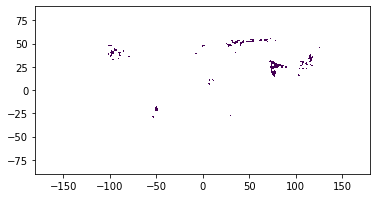

In [3]:
# small check that rasters can be loaded correctly 
with rio.open(soybeam_images[1]) as im:
    show(im)
    raster_crs = im.crs

# load the study areas and check that it has the same crs as the rasters
areas = gpd.read_file(DATA_BASE_PATH / "areas.geojson")
areas["region"] = ["india", "america"]

assert str(raster_crs).split(":")[1] == str(areas.crs).split(":")[1]

### Clip with `areas.geojson` and get the regions of interest

In [4]:
dest_dir = DATA_BASE_PATH / "areas"
dest_dir.mkdir(exist_ok=True)

In [5]:
def make_out_filename(image_path: Path, region: str) -> str:
    name, ext = image_path.name.split(".")
    return f"{name.replace('global', region)}.{ext}"


rasters = []
for im in soybeam_images:
    with rio.open(im) as src:
        # apply mask for each area and save new clipped raster
        for area in areas.itertuples():
            out_image, out_transform = mask(src, shapes=[area.geometry], crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
                })

            with rio.open(dest_dir / make_out_filename(im, area.region), "w", **out_meta) as dest:
                dest.write(out_image)
                rasters.append(dest.name)

Now we have the areas of interest extractet and listed in `rasters` but it is still a bit messy to play around with it.
It is time to make some data organization helper with a `dataclass`.

In [6]:
@dataclass
class SpamData:
    filename: Path
    version: str
    region: str
    variable: str
    crop: str
    technology: str

    @classmethod
    def from_file(cls, filename: str):
        filename = Path(filename)
        attrs = filename.name.split(".")[0].split("_")
        return cls(filename, *attrs)

    def get_description(self) -> str:
        return f"{VARIABLES_MAP[self.variable]}, {TECHNOLOGY_MAP[self.technology]}"

In [7]:
rasters = [SpamData.from_file(f) for f in rasters]

Now we can filter things out easily

In [9]:
[r for r in rasters if r.region == "india"][:3]

[SpamData(filename=PosixPath('data/areas/spam2010V2r0_india_A_SOYB_I.tif'), version='spam2010V2r0', region='india', variable='A', crop='SOYB', technology='I'),
 SpamData(filename=PosixPath('data/areas/spam2010V2r0_india_A_SOYB_S.tif'), version='spam2010V2r0', region='india', variable='A', crop='SOYB', technology='S'),
 SpamData(filename=PosixPath('data/areas/spam2010V2r0_india_A_SOYB_A.tif'), version='spam2010V2r0', region='india', variable='A', crop='SOYB', technology='A')]

## Global Forest Change data preparation

## Visualize

In [10]:
def plot_map_on_ax(ax, raster_filename, areas, proj, **imshow_kwargs):
    with rio.open(raster_filename, "r") as src:
        im = src.read(1)
        extent = rio.plot.plotting_extent(src)

    # get the extent for the base map and add some room to have context
    x0, x1, y0, y1 = extent
    x0, x1, y0, y1 = x0 - 2, x1 + 2, y0 - 2, y1 + 2
    ax.set_extent([x0, x1, y0, y1], crs=proj)

    # add data extend boundary from areas.geojson
    areas_ax = areas.to_crs(proj.proj4_init).boundary.plot(ax=ax, linestyle=(0, (1, 5)), color="k", label="Data extent")
    ax.legend()

    # don't draw pixels with 0 value and no data (-1)
    im[im <= 0] = np.nan
    # rasterio.plot.show() doesn't work well when using cartopy
    # so using the cartopy patched imshow() instead
    im_ax = ax.imshow(im, transform=proj, extent=extent, **imshow_kwargs)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.OCEAN)
    return im_ax


def plot_spam_data(raster: SpamData):
    fig = plt.figure(figsize=(10, 5))
    proj = ccrs.PlateCarree()  # sets the cartopy map projection
    ax = fig.add_subplot(111, projection=proj)

    im_ax = plot_map_on_ax(ax, raster.filename, areas, proj, cmap="Reds")

    fig.colorbar(im_ax, ax=ax)
    ax.set_title(f"Soy Beam\n{raster.get_description()}")
    plt.tight_layout()

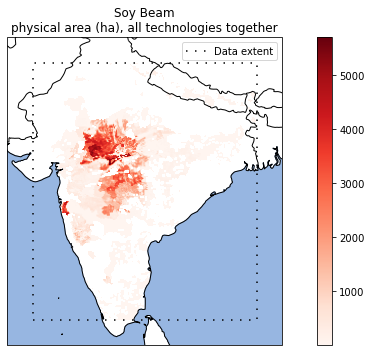

In [11]:
plot_spam_data(rasters[4])

In [12]:
def get_rasters_by_codes(rasters: list[SpamData], var: str, tech: str) -> list[SpamData]:
    """Filter raster list by variable, technology."""
    return [r for r in rasters if r.variable in var and r.technology in tech]


def compare_rasters(rasters: list[SpamData]):
    """Plots two rasters side by side"""
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=[14, 8])
    ax1 = fig.add_subplot(121, projection=proj)
    ax2 = fig.add_subplot(122, projection=proj)

    # get max and min value for both rasters so they can use the same intensity color scale
    # This solution is quite suboptimal since it reads the rasters before plotting :^/
    vmin, vmax = np.inf, 0
    for raster in rasters:
        with rio.open(raster.filename, "r") as src:
            im = src.read(1)
        vmin = np.min(im, initial=vmin)
        vmax = np.max(im, initial=vmax)

    for raster, ax in zip(rasters, [ax1, ax2]):
        im_ax = plot_map_on_ax(ax, raster.filename, areas, proj, vmin=vmin, vmax=vmax, cmap="Reds")
        ax.set_title("{}\n{}".format(*raster.get_description().split(", ")))
    # set the colorbar for the last processed raster
    fig.colorbar(im_ax, ax=[ax1, ax2])

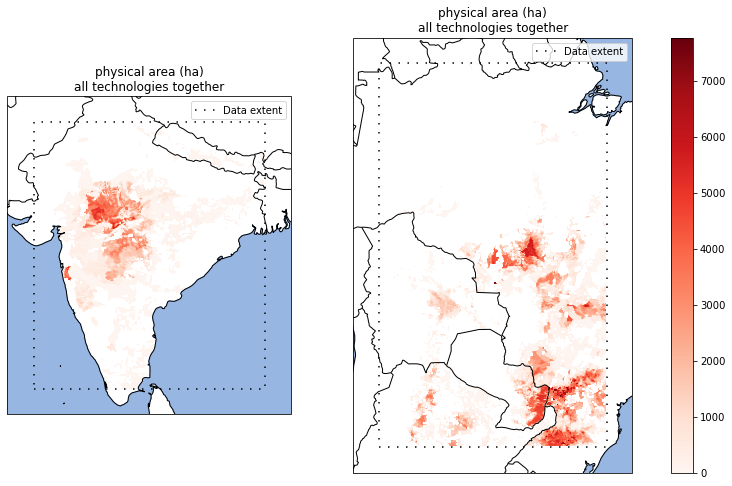

In [13]:
area_all_tech = get_rasters_by_codes(rasters, var="A", tech="A")
compare_rasters(area_all_tech)

## Analysis

This section is the actual analysis. 
Now that we have the tools to easily filter and show the data it will be clean and straight forward to get some insights.

### How is the yield afected by the technology used?

In [14]:
yield_rasters = get_rasters_by_codes(rasters, var="A", tech="IR")

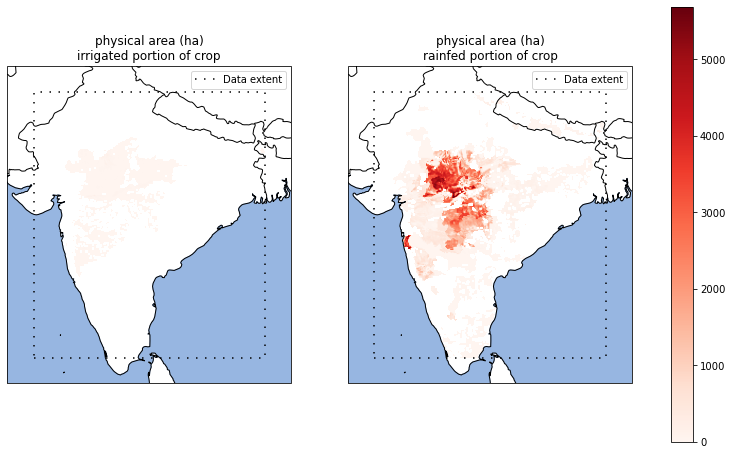

In [15]:
compare_rasters([r for r in yield_rasters if r.region == "india"])

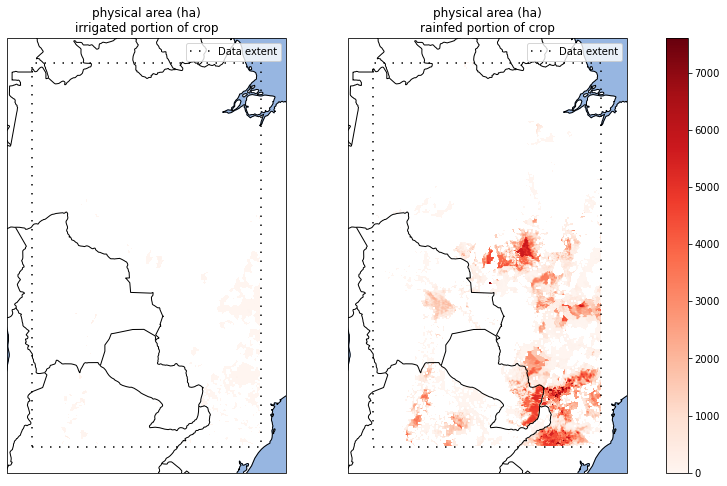

In [16]:
compare_rasters([r for r in yield_rasters if r.region == "america"])